# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler #, RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
np.random.seed(42)

In [2]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [10]:
X = fires_dt.drop('area', axis=1)
y = fires_dt['area']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train.shape
# X_test.shape
# y

(104, 12)

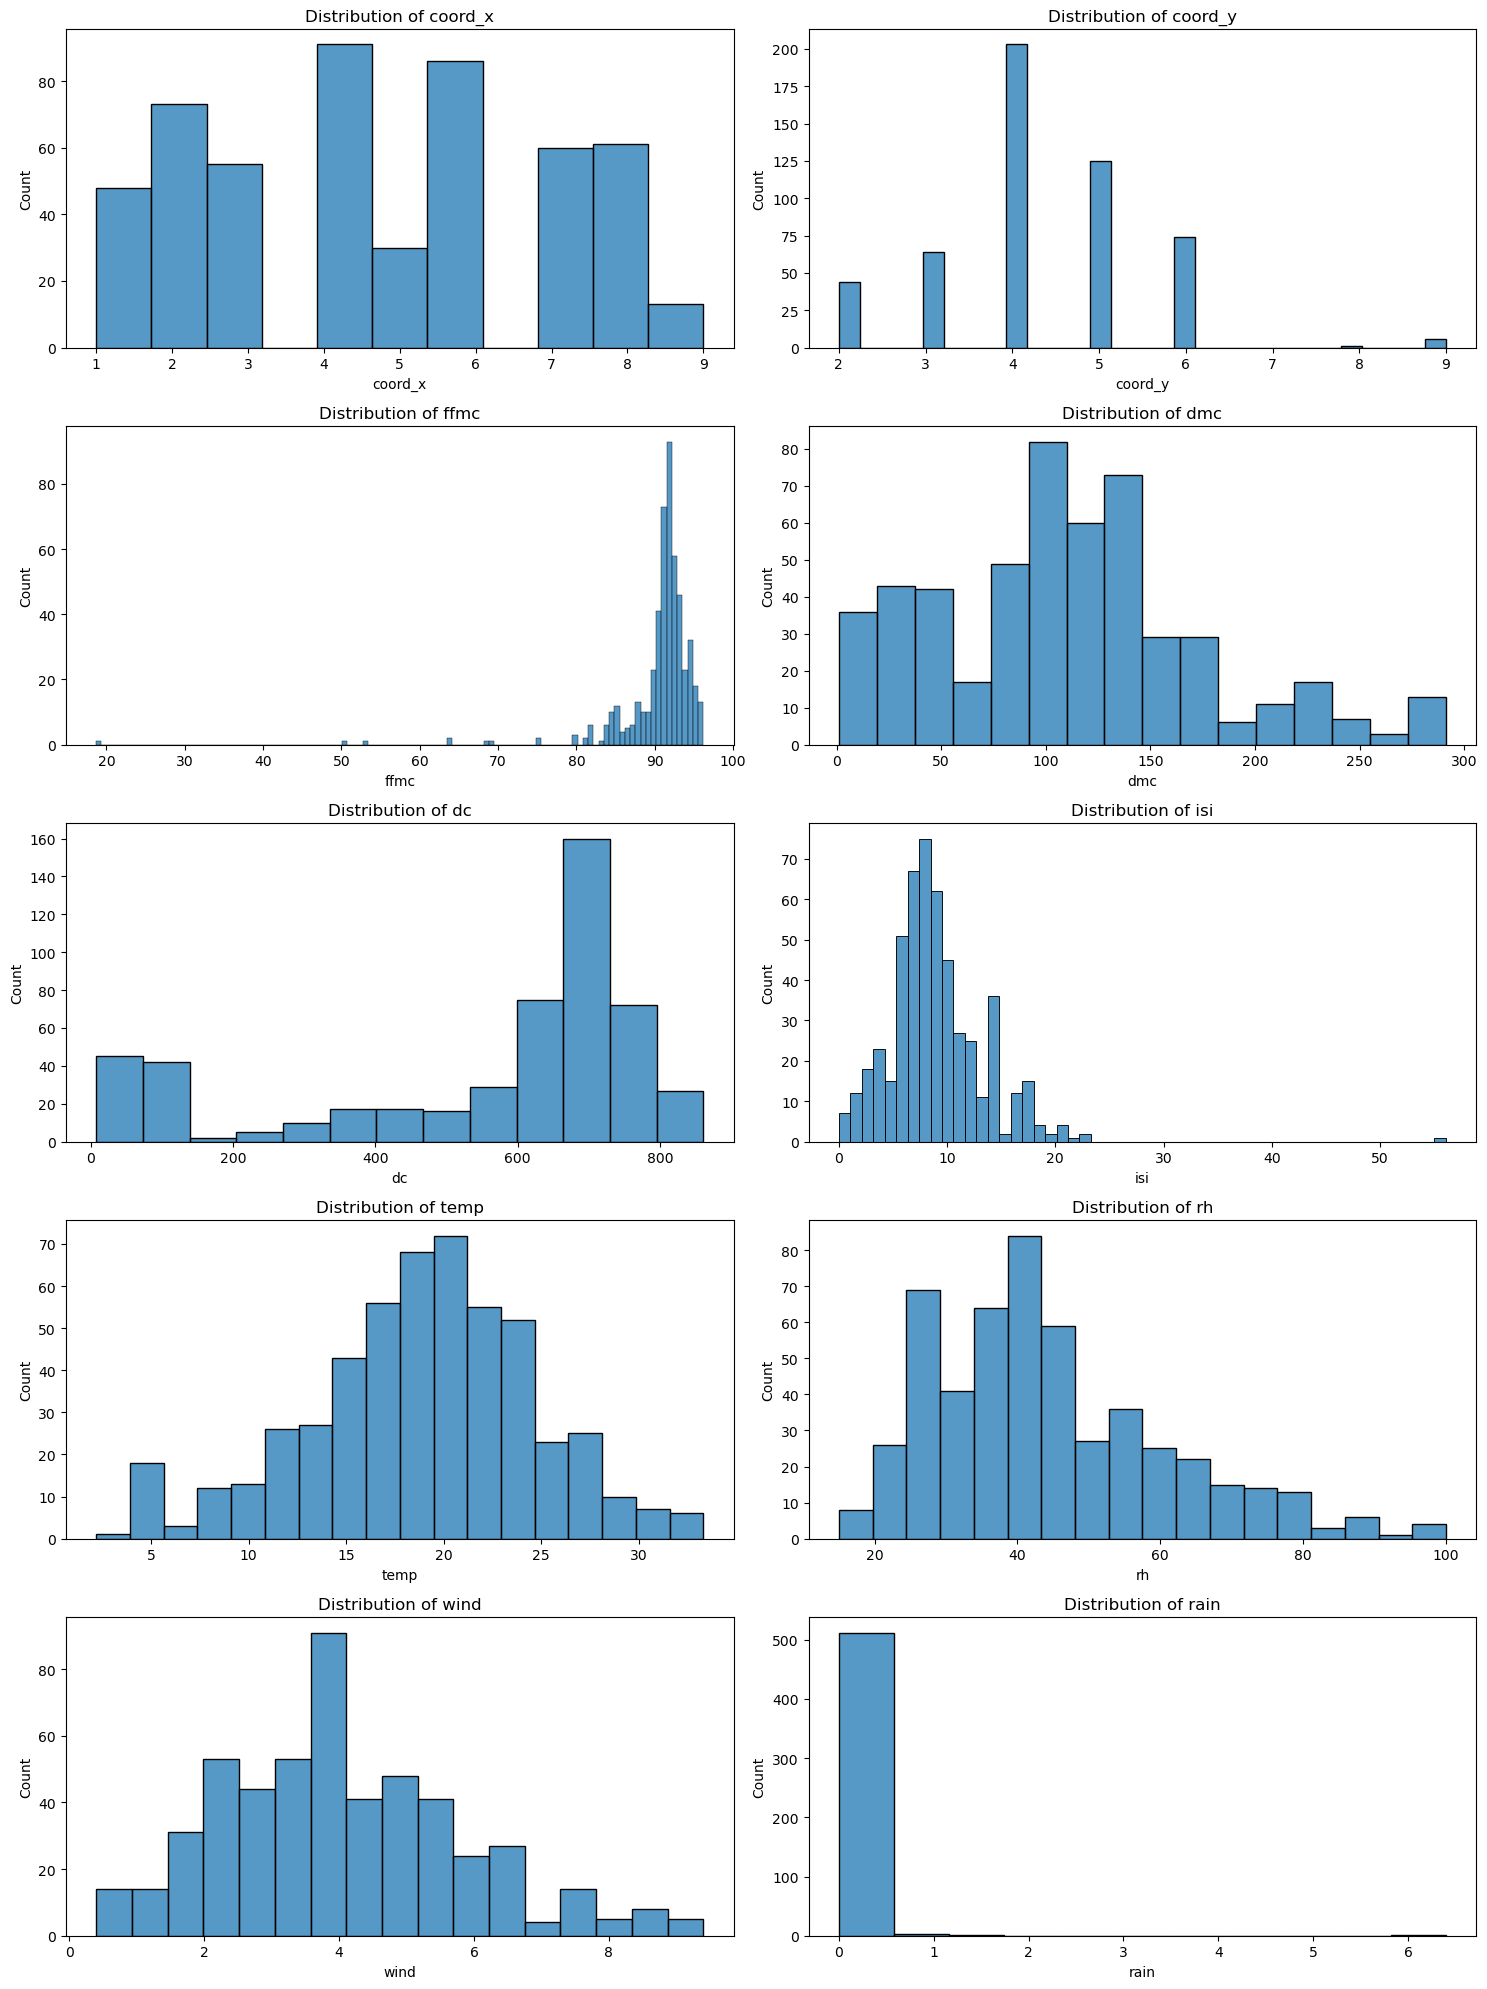


Skewness of numeric features:
coord_x     0.036246
coord_y     0.417296
ffmc       -6.575606
dmc         0.547498
dc         -1.100445
isi         2.536325
temp       -0.331172
rh          0.862904
wind        0.571001
rain       19.816344
dtype: float64
Original DMC statistics:
count    517.000000
mean     110.872340
std       64.046482
min        1.100000
25%       68.600000
50%      108.300000
75%      142.400000
max      291.300000
Name: dmc, dtype: float64

Log-transformed DMC statistics:
count    517.000000
mean       4.469552
std        0.844648
min        0.741937
25%        4.242765
50%        4.694096
75%        4.965638
max        5.677781
Name: dmc, dtype: float64

Power-transformed DMC statistics:
count      517.000000
mean     16386.693617
std      17379.235255
min          1.210000
25%       4705.960000
50%      11728.890000
75%      20277.760000
max      84855.690000
Name: dmc, dtype: float64


In [26]:
import seaborn as sns

numeric_features = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
categorical_features = ['month', 'day']

# Examine distributions of numeric features
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.ravel()

for idx, col in enumerate(numeric_features):
    sns.histplot(data=fires_dt, x=col, ax=axes[idx])
    axes[idx].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

# Skewness values
skewness = fires_dt[numeric_features].skew()
print("\nSkewness of numeric features:")
print(skewness)

# Show how transformations affect data
example_feature = fires_dt['dmc']  # highly skewed feature

print("Original DMC statistics:")
print(example_feature.describe())

print("\nLog-transformed DMC statistics:")
print(np.log1p(example_feature).describe())

print("\nPower-transformed DMC statistics:")
print(np.power(example_feature, 2).describe())

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [27]:
# CSV (and fires_dt.info()) shows that all the featues except day and month are numeric
numeric_features = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
# And categorical features are respectively:
categorical_features = ['month', 'day']

preproc1 = ColumnTransformer(
    transformers=[
        ('numeric', StandardScaler(), numeric_features),
        ('categorical', OneHotEncoder(
            drop='first', 
            sparse_output=False,
            handle_unknown='infrequent_if_exist'
        ), categorical_features)
    ],
    remainder='drop'
)

preproc1

ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('categorical',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='infrequent_if_exist',
                                               sparse_output=False),
                                 ['month', 'day'])])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [28]:
# Transformers for non-linear transformations
log_transformer = FunctionTransformer(func=np.log1p)
power_transformer = FunctionTransformer(func=lambda x: np.power(x, 2))

log_features = ['dmc', 'dc', 'isi']
power_features = ['wind', 'rain']
regular_features = ['coord_x', 'coord_y', 'ffmc', 'temp', 'rh']

preproc2 = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), regular_features),
        ('log', Pipeline([
            ('log', log_transformer),
            ('scale', StandardScaler())
        ]), log_features),
        ('power', Pipeline([
            ('power', power_transformer),
            ('scale', StandardScaler())
        ]), power_features),
        ('cat', OneHotEncoder(
            drop='first', 
            sparse_output=False,
            handle_unknown='infrequent_if_exist'
        ), categorical_features)
    ],remainder='drop'
)

preproc2

ColumnTransformer(transformers=[('scale', StandardScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'temp', 'rh']),
                                ('log',
                                 Pipeline(steps=[('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>)),
                                                 ('scale', StandardScaler())]),
                                 ['dmc', 'dc', 'isi']),
                                ('power',
                                 Pipeline(steps=[('power',
                                                  FunctionTransformer(func=<function <lambda> at 0x167b76280>)),
                                                 ('scale', StandardScaler())]),
                                 ['wind', 'rain']),
                                ('cat',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='infrequent_if_exist',
                                               sparse_output=False),
                                 ['month', 'day'])])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [29]:
# Pipeline A = preproc1 + baseline

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge

# Pipeline A = preproc1 + baseline (using Ridge as baseline)
pipeline_A = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', Ridge(random_state=42))
])

In [30]:
# Pipeline B = preproc2 + baseline

pipeline_B = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', Ridge(random_state=42))
])

In [31]:
# Pipeline C = preproc1 + advanced model

from sklearn.ensemble import RandomForestRegressor

pipeline_C = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [32]:
# Pipeline D = preproc2 + advanced model

pipeline_D = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

# Create RMSE scorer
rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)))

# Parameter grid for Ridge pipelines (A and B)
ridge_param_grid = {
    'regressor__alpha': [0.1, 1.0, 10.0, 100.0],
    'regressor__solver': ['auto', 'svd', 'cholesky']
}

# Parameter grid for Random Forest pipelines (C and D)
rf_param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 5]
}


In [34]:
# Tune Pipeline A
grid_A = GridSearchCV(
    pipeline_A, 
    ridge_param_grid,
    cv=5,
    scoring=rmse_scorer,
    n_jobs=-1
)
grid_A.fit(X_train, y_train)
print("Best parameters for Pipeline A:", grid_A.best_params_)
print("Best RMSE score for Pipeline A:", -grid_A.best_score_)  # Negative because of scorer


Best parameters for Pipeline A: {'regressor__alpha': 0.1, 'regressor__solver': 'svd'}
Best RMSE score for Pipeline A: -41.168377610347505


/Users/asm/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/asm/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/asm/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/asm/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  war

In [35]:
# Tune Pipeline B
grid_B = GridSearchCV(
    pipeline_B, 
    ridge_param_grid,
    cv=5,
    scoring=rmse_scorer,
    n_jobs=-1
)
grid_B.fit(X_train, y_train)
print("\nBest parameters for Pipeline B:", grid_B.best_params_)
print("Best RMSE score for Pipeline B:", -grid_B.best_score_)



Best parameters for Pipeline B: {'regressor__alpha': 0.1, 'regressor__solver': 'svd'}
Best RMSE score for Pipeline B: -60.81610898854442


/Users/asm/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/asm/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/asm/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/asm/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  war

In [19]:
# Tune Pipeline C
grid_C = GridSearchCV(
    pipeline_C, 
    rf_param_grid,
    cv=5,
    scoring=rmse_scorer,
    n_jobs=-1
)
grid_C.fit(X_train, y_train)
print("\nBest parameters for Pipeline C:", grid_C.best_params_)
print("Best RMSE score for Pipeline C:", -grid_C.best_score_)


/Users/asm/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/asm/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/asm/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/asm/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  war


Best parameters for Pipeline C: {'regressor__max_depth': 20, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
Best RMSE score for Pipeline C: -49.134754272273966


In [20]:
# Tune Pipeline D
grid_D = GridSearchCV(
    pipeline_D, 
    rf_param_grid,
    cv=5,
    scoring=rmse_scorer,
    n_jobs=-1
)
grid_D.fit(X_train, y_train)
print("\nBest parameters for Pipeline D:", grid_D.best_params_)
print("Best RMSE score for Pipeline D:", -grid_D.best_score_)

/Users/asm/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/asm/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/asm/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/asm/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  war


Best parameters for Pipeline D: {'regressor__max_depth': None, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
Best RMSE score for Pipeline D: -49.27072447487602


# Evaluate

+ Which model has the best performance?

Model Performance Comparison:
                        Model  Train RMSE  Test RMSE  Train R2   Test R2
Pipeline A (Preproc1 + Ridge)   44.457426 107.787342  0.049620  0.014392
Pipeline B (Preproc2 + Ridge)   44.572211 108.105512  0.044706  0.008565
   Pipeline C (Preproc1 + RF)   20.396284 109.748454  0.799963 -0.021799
   Pipeline D (Preproc2 + RF)   19.943118 109.198433  0.808753 -0.011583


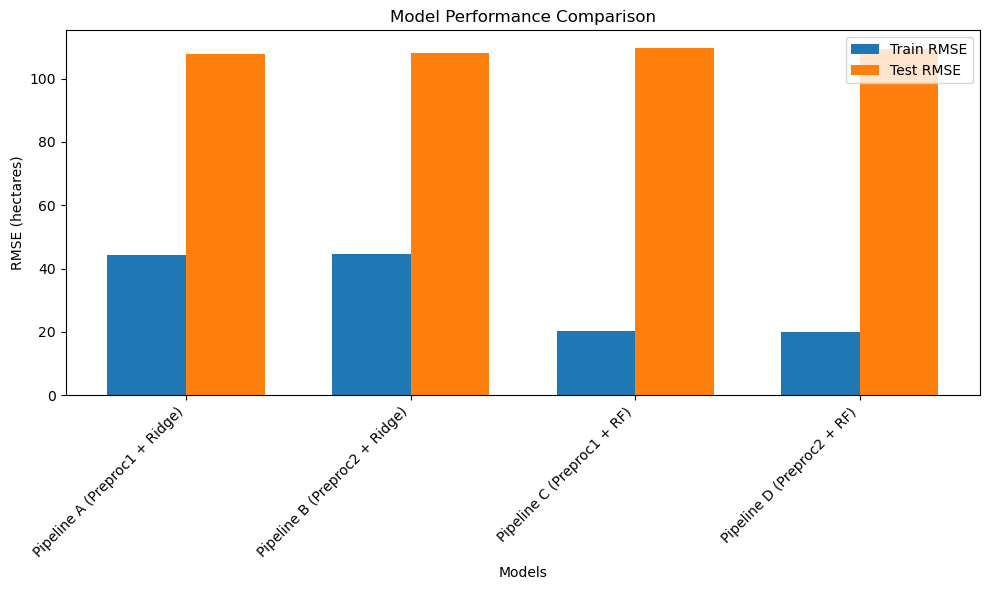


Best performing model: Pipeline A (Preproc1 + Ridge)
Best Test RMSE: 107.79 hectares


In [22]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Calculate R2 (for additional insight)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    return {
        'Model': model_name,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train R2': train_r2,
        'Test R2': test_r2
    }

# Evaluate all models
results = []
results.append(evaluate_model(grid_A.best_estimator_, X_train, X_test, y_train, y_test, 'Pipeline A (Preproc1 + Ridge)'))
results.append(evaluate_model(grid_B.best_estimator_, X_train, X_test, y_train, y_test, 'Pipeline B (Preproc2 + Ridge)'))
results.append(evaluate_model(grid_C.best_estimator_, X_train, X_test, y_train, y_test, 'Pipeline C (Preproc1 + RF)'))
results.append(evaluate_model(grid_D.best_estimator_, X_train, X_test, y_train, y_test, 'Pipeline D (Preproc2 + RF)'))

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Display results
print("Model Performance Comparison:")
print(results_df.to_string(index=False))

# Visualize RMSE comparison
plt.figure(figsize=(10, 6))
models = results_df['Model']
x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, results_df['Train RMSE'], width, label='Train RMSE')
plt.bar(x + width/2, results_df['Test RMSE'], width, label='Test RMSE')

plt.xlabel('Models')
plt.ylabel('RMSE (hectares)')
plt.title('Model Performance Comparison')
plt.xticks(x, models, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Find best model
best_idx = results_df['Test RMSE'].idxmin()
best_model = results_df.iloc[best_idx]
print(f"\nBest performing model: {best_model['Model']}")
print(f"Best Test RMSE: {best_model['Test RMSE']:.2f} hectares")

# Export

+ Save the best performing model to a pickle file.

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

*(Answer here.)*

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.